# Chapter 07 [앙상블 학습과 랜덤 포레스트]

<span style="color:purple">****앙상블 학습(Ensemble Learning)***</span> : 일련의 예측기(즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있고, 이러한 일련의 예측기가 앙상블 학습<br>
<br>
<span style="color:purple">****랜덤 포레스트(Random Forest)***</span> : 결정 트리의 앙상블

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Chapter 07 [ensemble_learning_and_random_forests]"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 7.1 투표 기반 분류기

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

그림 저장: law_of_large_numbers_plot


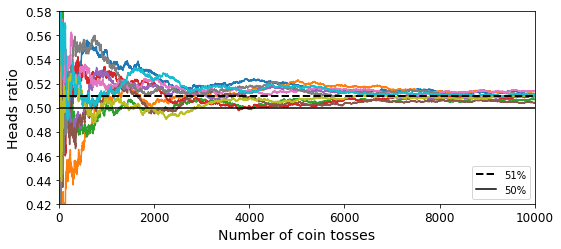

In [3]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


<span style="color:orange">**간접 투표(Soft Voting)**</span> : 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측하는 투표 방법

In [8]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 7.2 배깅과 페이스팅

수집 함수는 전형적으로 분류일 때는 **통계적 최빈값(statistical mode)**, 회귀에 대해서는 **평균**을 계산

### 7.2.1 사이킷런의 배깅과 페이스팅

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


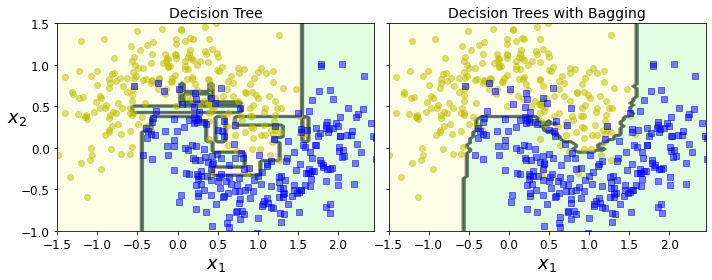

In [14]:
fix, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

**<span style="color:blue">앙상블은 비슷한 편향에서 더 작은 분산을 만듦</span>(훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙)**

### 7.2.2 oob 평가

<span style="color:orange">**배깅(Bagging)**</span>을 사용하면 평균적으로 각 예측기에 **훈련 샘플의 63% 정도만 샘플링**됨<br>
<span style="color:green">**oob(out-of-bag) 샘플**</span> : 선택되지 않은 **나머지 37%**

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [16]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 7.3 랜덤 패치와 랜덤 서브스페이스

**랜덤 패치 방식(random patches method)** : 훈련 특성과 샘플을 모두 샘플링<br>
**랜덤 서브스페이스 방식(random subspaces method)** : 훈련 샘플을 모두 사용하고 특성은 샘플링

## 7.4 랜덤 포레스트

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [20]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
np.sum(y_pred == y_pred_rf) / len(y_pred)   # 거의 예측이 동일

0.984

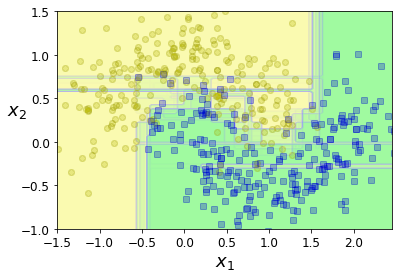

In [22]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

### 7.4.1 엑스트라 트리

**엑스트라 트리(Extra-Trees)** : 극단적으로 무작위한 트리의 랜덤 포레스트

### 7.4.2 특성 중요도

랜덤 포레스트의 장점은 **특성의 상대적 중요도를 측정하기 쉽다는 것**(<span style="color:brown">**feature_importances_ 변수**</span>에 저장)

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [24]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [25]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


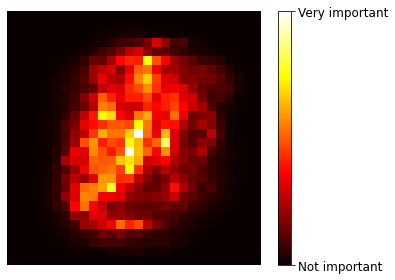

In [28]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## 7.5 부스팅

<span style="color:orange">**부스팅(Boosting)**</span> : 약한 학습기를 여러 개 연결하여 강한 학습기를 만든는 앙상블 방법으로, **앞의 모델을 보완해나가면서** 일련의 예측기를 학습시키는 것

### 7.5.1 AdaBoost(에이다부스트)

<span style="color:blue">**AdaBoost(에이다부스트)**</span> : **이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것**으로, 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨

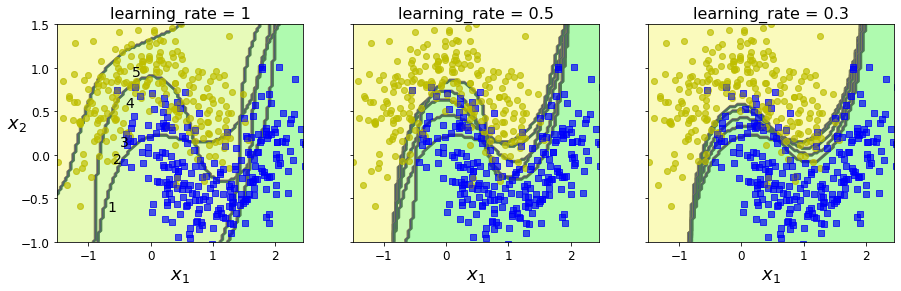

In [29]:
m = len(X_train)

fix, axes = plt.subplots(ncols=3, figsize=(15,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5), (2, 0.3)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 **에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가**

<span style="color:gray">**연속된 학습 기법의 중요한 단점** : 학습의 병렬화(또는 분할)가 불가능하기 때문에 배깅이나 패이스팅만큼 확장성이 높지 않음</span>

- **$j$번째 예측기의 가중치가 적용된 에러율**<br>

<center>$r_j = \frac{\sum_{i=1}^m w^{(i)} ← \hat y_j^{(i)} \neq y^{(i)}}{\sum_{i=1}^m w^{(i)}}$</center><br>
여기서 $\hat y_i^{(i)}$는 $i$번째 샘플에 대한 $j$번째 예측기의 예측<br>
<br>

- **예측기 가중치**<br>

<center>$\alpha_j = \eta log \frac{1-r_j}{r_j}$</center><br>
<br>

- **가중치 업데이트 규칙**<br>
\begin{split}
\\
&\text{$w^{(i)} ← $}\begin{cases}
w^{(i)} ← \hat y_j^{(i)} = y^{(i)}d일 때\\
w^{(i)} \exp(\alpha_j) ← \hat y_j^{(i)} \neq y^{(i)}일 때\\
\end{cases}
\end{split}
여기서 $i = 1, 2, ..., m$<br>
<br>

- **에이다부스트 예측**<br>
$\hat y(x) = argmax_x\sum_{i=1}^N\alpha_j ← \hat y_j(x)=k$

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

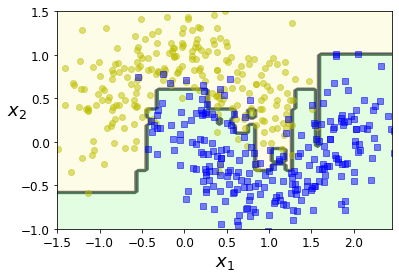

In [31]:
plot_decision_boundary(ada_clf, X, y)

### 7.5.2 Gradient Boosting

**<span style="color:blue">Gradient Boosting</span>** : 앙상블에 이전까지의 **오차를 보정하도록 예측기를 순차적으로 추가**하는 모델로, 이전 예측기가 만든 <span style="color:brown">**잔여 오차**</span>에 새로운 예측기를 학습

In [32]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [34]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [35]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [36]:
X_new = np.array([[0.8]])

In [37]:
# 모든 트리의 예측을 더함
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

In [38]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

그림 저장: gradient_boosting_plot


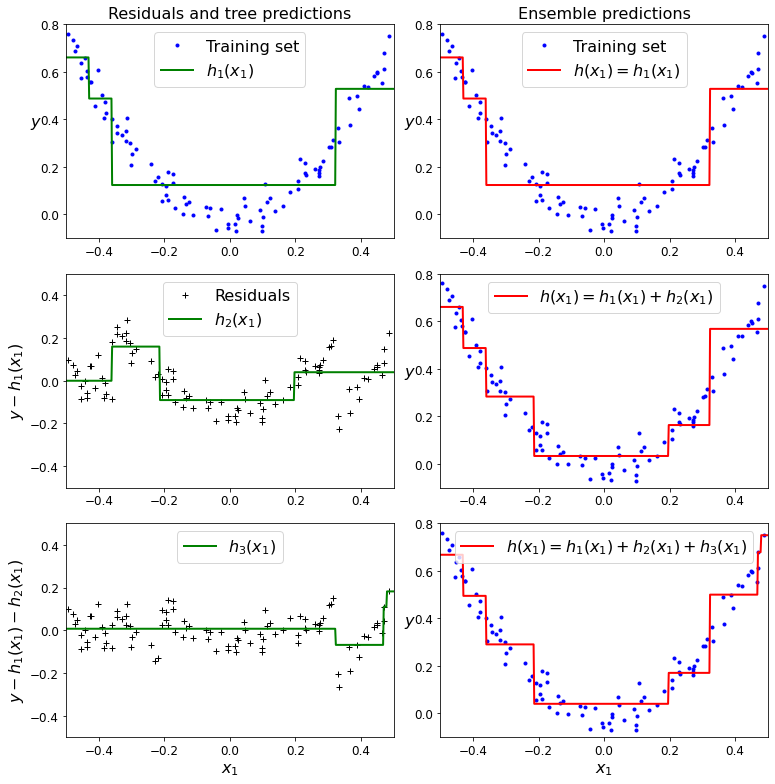

In [39]:
plt.figure(figsize=(11, 11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=5, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=5,
                          random_state=42)

In [41]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=10, learning_rate=1.0, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=10,
                          random_state=42)

In [42]:
gbrt_slow2 = GradientBoostingRegressor(max_depth=2, n_estimators=50, learning_rate=1.0, random_state=42)
gbrt_slow2.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=50,
                          random_state=42)

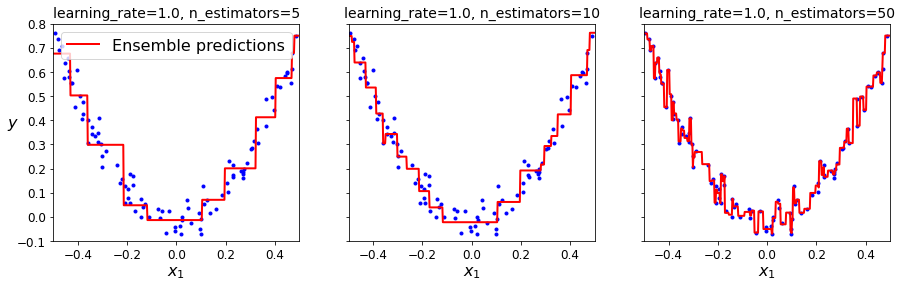

In [43]:
fix, axes = plt.subplots(ncols=3, figsize=(15,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.sca(axes[2])
plot_predictions([gbrt_slow2], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow2.learning_rate, gbrt_slow2.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

**조기 종료 기법** : **`staged_predict()`**

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [45]:
min_error = np.min(errors)

min_error

0.002712853325235463

그림 저장: early_stopping_gbrt_plot


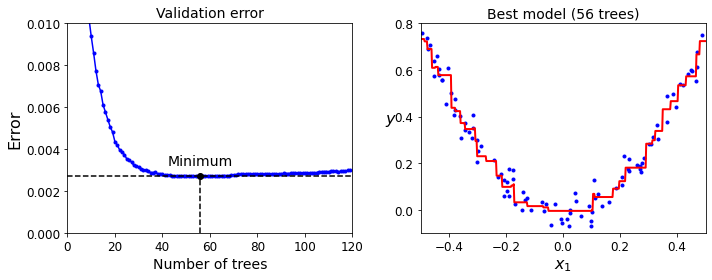

In [46]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In [47]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break   # early stopping

연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춤

In [48]:
print(gbrt.n_estimators)

61


In [49]:
print("Minimum validation MSE :", min_val_error)

Minimum validation MSE : 0.002712853325235463


### 7.5.3 XGBoost

In [50]:
try:
    import xgboost
except ImportError as ex:
    print("에러 : xgboost 라이브러리가 설치되지 않았습니다.")
    xgboost = None

In [51]:
if xgboost is not None:                            # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE :", val_error)           # 책에 없음

Validation MSE : 0.004000408205406276


In [52]:
if xgboost is not None:                             # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)   # 책에 없음
    print("Validation MSE :", val_error)            # 책에 없음

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE : 0.002630868681577655


## 7.6 스태킹

<span style="color:orange">**스태킹(Stacking)**</span> : 예측기가 각각 다른 값을 예측하고 마지막 예측기(**블렌더(blender, 또는 메타 학습기(meta learner)**)가 이 예측을 입력으로 받아 최종 예측하는 방법)

## 투표 기반 분류기

문제: _MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 40,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플)._

MNIST 데이터셋은 앞에서 로드했습니다.

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

In [55]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

문제: _그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킵니다._

In [56]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [57]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [58]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [59]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9601]

선형 SVM이 다른 분류기보다 성능이 많이 떨어집니다. 그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 두겠습니다.

문제: _그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요._

In [60]:
from sklearn.ensemble import VotingClassifier

In [61]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [62]:
voting_clf = VotingClassifier(named_estimators)

In [63]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [64]:
voting_clf.score(X_val, y_val)

0.9693

In [65]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.0, 0.0, 0.0, 0.0]

SVM 모델을 제거해서 성능이 향상되는지 확인해 보죠. 다음과 같이 `set_params()`를 사용하여 `None`으로 지정하면 특정 예측기를  제외시킬 수 있습니다:

In [66]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

예측기 목록이 업데이트되었습니다:

In [67]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

하지만 훈련된 예측기 목록은 업데이트되지 않습니다:

In [68]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

`VotingClassifier`를 다시 훈련시키거나 그냥 훈련된 예측기 목록에서 SVM 모델을 제거할 수 있습니다:

In [69]:
del voting_clf.estimators_[2]

`VotingClassifier`를 다시 평가해 보죠:

In [70]:
voting_clf.score(X_val, y_val)

0.973

훨씬 나아졌네요! SVM 모델이 성능을 저하시켰습니다. 이제 간접 투표 분류기를 사용해 보죠. 분류기를 다시 훈련시킬 필요는 없고 `voting`을 `"soft"`로 지정하면 됩니다:

In [71]:
voting_clf.voting = "soft"

In [72]:
voting_clf.score(X_val, y_val)

0.9669

이 경우는 직접 투표 방식이 낫네요.

_앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?_

In [73]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9706

In [74]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.0, 0.0, 0.0]

여기서는 투표 기반 분류기가 최선의 모델의 오차율을 아주 조금만 감소시킵니다.

## 스태킹 앙상블

문제: _이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요._

In [75]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [76]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [77]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [78]:
rnd_forest_blender.oob_score_

0.9682

이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어, `MLPClassifier`)를 시도해 볼 수 있습니다. 그런 늘 하던대로 다음 교차 검증을 사용해 가장 좋은 것을 선택합니다.

문제: _축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?_

In [79]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [80]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [81]:
from sklearn.metrics import accuracy_score

In [82]:
accuracy_score(y_test, y_pred)

0.9666